# Phase 2, Part 1: Data Preparation

## 1. Import Pandas and Load the Data

In [11]:
import pandas as pd

# Load the core datasets
orders = pd.read_csv('olist_orders_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
translations = pd.read_csv('product_category_name_translation.csv')

## 2. Merge the DataFrames 

In [12]:
# --- Merging Process ---

# Merge orders with order items (one order can have multiple items)
df = pd.merge(orders, items, on='order_id', how='left')

# Merge product information
df = pd.merge(df, products, on='product_id', how='left')

# Merge customer information
df = pd.merge(df, customers, on='customer_id', how='left')

# Merge payment information
df = pd.merge(df, payments, on='order_id', how='left')

# Merge the English category names
df = pd.merge(df, translations, on='product_category_name', how='left')

## 3. Initial Inspection

In [13]:
# --- Initial Inspection ---

print("DataFrame Info after all merges:")
df.info()

print("\nFirst 5 rows:")
print(df.head())

DataFrame Info after all merges:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118434 non-null  object 
 1   customer_id                    118434 non-null  object 
 2   order_status                   118434 non-null  object 
 3   order_purchase_timestamp       118434 non-null  object 
 4   order_approved_at              118258 non-null  object 
 5   order_delivered_carrier_date   116360 non-null  object 
 6   order_delivered_customer_date  115037 non-null  object 
 7   order_estimated_delivery_date  118434 non-null  object 
 8   order_item_id                  117604 non-null  float64
 9   product_id                     117604 non-null  object 
 10  seller_id                      117604 non-null  object 
 11  shipping_limit_date            117604 non-null  object 
 1

# Phase 2, Part 2: Data Cleaning

## 1.Convert to Datetime

In [4]:
# Convert all timestamp columns to datetime objects
date_columns = ['order_purchase_timestamp', 'order_approved_at', 
                'order_delivered_carrier_date', 'order_delivered_customer_date', 
                'order_estimated_delivery_date']

for col in date_columns:
    df[col] = pd.to_datetime(df[col])

## 2.Handle Missing Values

In [7]:
# Remove rows where product_id is null and re-assign the DataFrame
df = df.dropna(subset=['product_id'])

# Fill missing English product category names and re-assign the column
df['product_category_name_english'] = df['product_category_name_english'].fillna('unknown')

print("Missing values handled successfully using the corrected method.")

Missing values handled successfully using the corrected method.


## 3. Feature Engineering: Create New Time-Based Columns

In [9]:
# Extract year, month, and day of week for trend analysis
df['order_purchase_year'] = df['order_purchase_timestamp'].dt.year
df['order_purchase_month'] = df['order_purchase_timestamp'].dt.month
df['order_purchase_dayofweek'] = df['order_purchase_timestamp'].dt.dayofweek # Monday=0, Sunday=6

## 4. Export the Cleaned Data

In [10]:
# Save the final, cleaned dataset
df.to_csv('olist_cleaned_master_data.csv', index=False)

print("\nCleaning complete! 'olist_cleaned_master_data.csv' is ready for Power BI.")
print("\nFinal data info:")
df.info()


Cleaning complete! 'olist_cleaned_master_data.csv' is ready for Power BI.

Final data info:
<class 'pandas.core.frame.DataFrame'>
Index: 117604 entries, 0 to 118433
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117604 non-null  object        
 1   customer_id                    117604 non-null  object        
 2   order_status                   117604 non-null  object        
 3   order_purchase_timestamp       117604 non-null  datetime64[ns]
 4   order_approved_at              117589 non-null  datetime64[ns]
 5   order_delivered_carrier_date   116359 non-null  datetime64[ns]
 6   order_delivered_customer_date  115037 non-null  datetime64[ns]
 7   order_estimated_delivery_date  117604 non-null  datetime64[ns]
 8   order_item_id                  117604 non-null  float64       
 9   product_id                     117604 non-null  

# Phase 3: Exploratory Data Analysis (EDA)

## 1. Imports for Plotting

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for our plots
sns.set_style('whitegrid')

## 2. Question 1: What are the monthly sales trends?

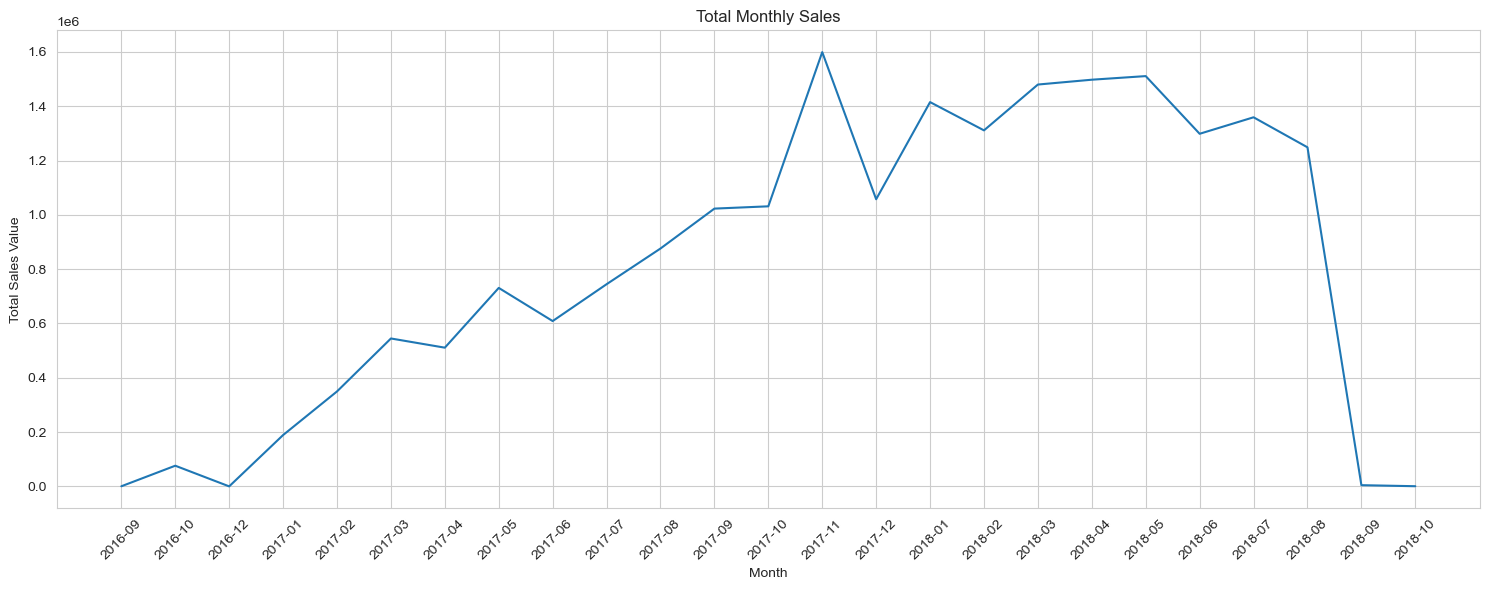

In [16]:
# First, ensure order_purchase_timestamp is a datetime type
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Group data by month and sum the payment value
df['order_purchase_year_month'] = df['order_purchase_timestamp'].dt.to_period('M')
monthly_sales = df.groupby('order_purchase_year_month')['payment_value'].sum().reset_index()

# Convert Period to timestamp for plotting
monthly_sales['order_purchase_year_month'] = monthly_sales['order_purchase_year_month'].astype(str)

# Plot the monthly sales
plt.figure(figsize=(15, 6))
sns.lineplot(x='order_purchase_year_month', y='payment_value', data=monthly_sales)
plt.title('Total Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

## 3. Question 2: Which are the top 10 product categories by sales?

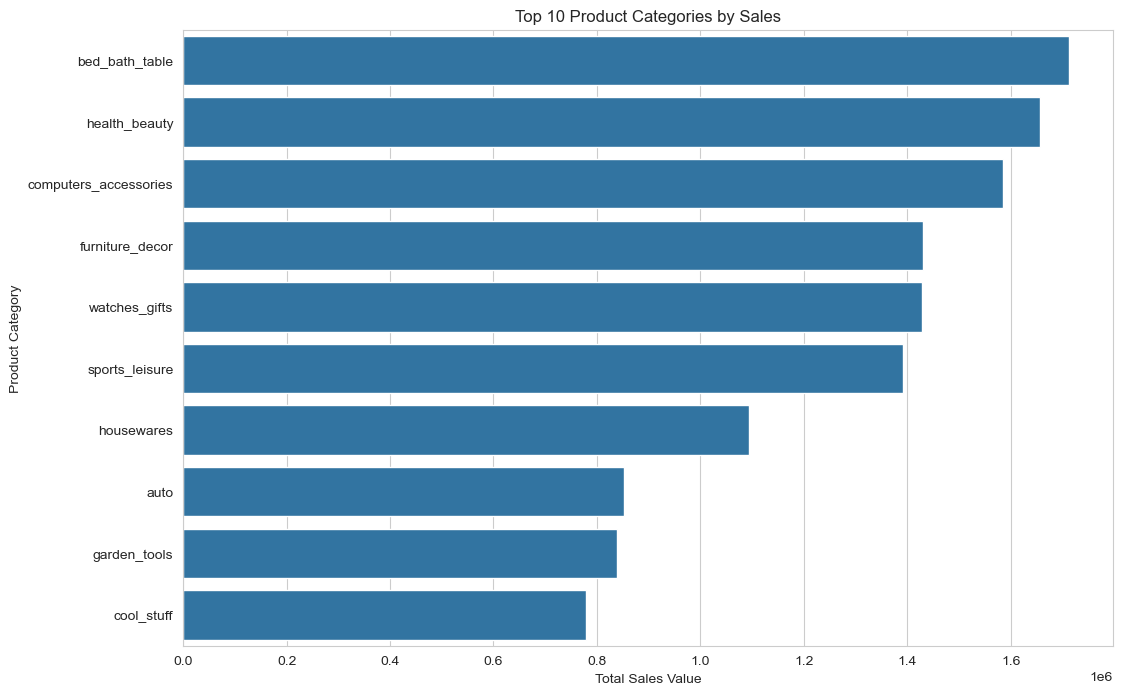

In [17]:
# Group by product category and sum payment value
top_categories = df.groupby('product_category_name_english')['payment_value'].sum().nlargest(10).reset_index()

# Plot the top 10 categories
plt.figure(figsize=(12, 8))
sns.barplot(x='payment_value', y='product_category_name_english', data=top_categories, orient='h')
plt.title('Top 10 Product Categories by Sales')
plt.xlabel('Total Sales Value')
plt.ylabel('Product Category')
plt.show()

## 4. Question 3: Which are the top 10 states by number of orders?

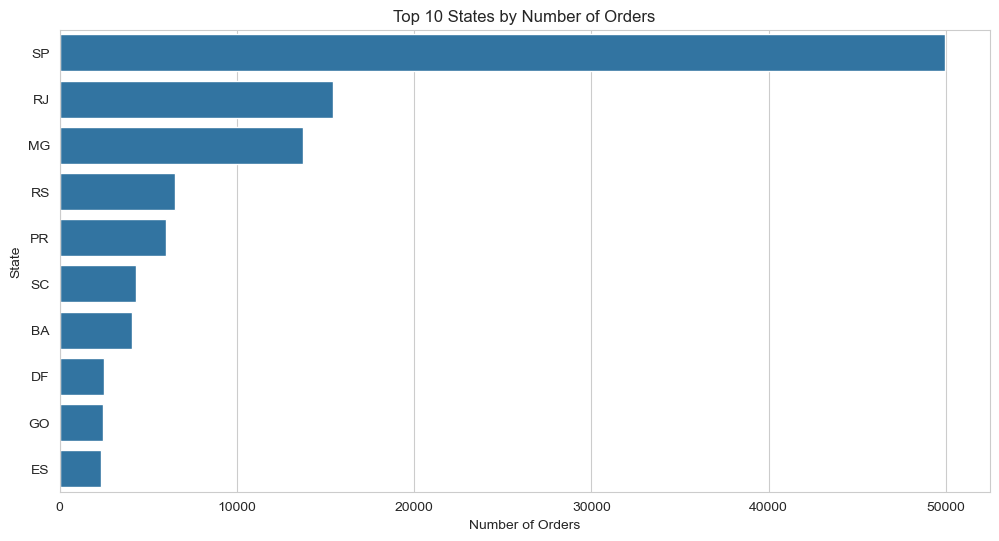

In [18]:
# Group by customer state and count the orders
top_states = df['customer_state'].value_counts().nlargest(10).reset_index()
top_states.columns = ['state', 'number_of_orders']

# Plot the top 10 states
plt.figure(figsize=(12, 6))
sns.barplot(x='number_of_orders', y='state', data=top_states, orient='h')
plt.title('Top 10 States by Number of Orders')
plt.xlabel('Number of Orders')
plt.ylabel('State')
plt.show()